In [1]:
import numpy as np
import scipy as sci
import jax 
import jax.numpy as jnp
from src.plotting_defaults import plotting_defaults
from hashlib import new
import matplotlib.animation as animation
from matplotlib import style
from matplotlib.animation import FuncAnimation
from random import randint
from scipy.optimize import curve_fit
from scipy.constants import Boltzmann as k
from src.glycerine_conc import glycerine_calc
import seaborn as sns
import scipy
import os
import matplotlib.pyplot as plt
from pandas import plotting
from scipy.interpolate import UnivariateSpline


In [2]:
path = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/"
FILE_LOCATION = path + "glycerine_tracks/glycerine_20.xml"
INDEX_NUM = 0
IMMERSON_LENS = True

In [3]:
def load_data(filename, multi_particle_index = 0):


    if filename.endswith("csv"):
        data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    else:
        from src.xml2csv import xml2csv
        #multi_particle_index used to determine what track to use if there are multiple (usually from the xaml file)
        a = xml2csv(filename, 2)
        data = a[multi_particle_index]
        data = np.array(data)

    return data


@jax.jit
def pearson_corr_coeff(pred, y):
    """
    Calculates pearson coeff.
    """
    pred = jnp.array(pred)
    y = jnp.array(y)    
    R = jnp.corrcoef(pred, y)[1, 0]
    
    return R

@jax.jit
def spearmen_corr_coeff(pred, y):
    
    rank_pred = jnp.argsort(jnp.argsort(pred))
    rank_y = jnp.argsort(jnp.argsort(y))
    val =  pearson_corr_coeff(rank_pred, rank_y)             
    
    return val


def msd_func(data, intervals=1, time_step=1, frame_rate=62.0, immersion=IMMERSON_LENS):
    """
    Data = [b, ] 
    """
    intervals = np.arange(1, len(data))
    data_store = []
    time_step = 1 / frame_rate
    #calculate the intervals between points

    avg_square_dev = []
    std_square_dev = []
    time_interval = []
    if immersion:
        calibration_factor = 0.6*1e-3*0.1/979.3
    else:
        calibration_factor = (0.1*0.001)/1094.4

    data = data * calibration_factor

    for interval in intervals:
        data_store = []
        mean_square_deviation = []


        for i in range(0, len(data), interval):
            if i == 0:
                data_store.append(0)
                mean_square_deviation.append(0)
                

            else:
                
                data_store.append(data[i] - data[i-1])
                
                mean_square_deviation.append((data[i] - data[i-interval])**2)

        time_interval.append(time_step * interval)

        avg_square_dev.append(np.mean ( mean_square_deviation ))

        sigma = (np.std(mean_square_deviation))/(2 * np.sqrt( np.mean(mean_square_deviation)))
        sigma = (np.std(mean_square_deviation)) / np.sqrt(np.shape(mean_square_deviation)[0])
        std_square_dev.append(sigma)
        
    

    return time_interval, avg_square_dev, std_square_dev

def chi_squared(pred, y , pred_error):
    

    chi_sqr = jnp.sum((pred - y) **2 / pred_error**2)
    reduced_chi_sqr = chi_sqr / (len(y) - 1)
    return reduced_chi_sqr


def visc_calc(gradient, diameter, temperature=291):

    
    #eta = (4 * k * temperature) / (3 * np.pi * gradient * diameter)
    temp_grad = gradient / 2 
    eta = (k * temperature) / (6 * np.pi * (diameter/2) * temp_grad)
    return eta


def func(x, a, b):
    return a * x + b

@jax.jit
def calculate_r_squared(pred, y):
    """
    Calculates r squared value
    """
    y_bar = np.mean(y)
    ss_tot = np.sum((y - y_bar)**2)
    ss_res = np.sum((y - pred)**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def kappa_calculator(data, temperature = 20.0):
    
    data = np.array(data)
    mu, sigma = scipy.stats.norm.fit(data)
    variance = sigma ** 2
    kappa = k * (temperature + 273) / variance

    #the biggest source of uncertainty is due to the uncertainty in the sigma
    num_data = np.shape(data)[0]
    varaince_unc = (num_data - 1)*(2 * variance**2) / num_data**2
    
    kappa_unc = (((kappa * 2 * k * (temperature +273)) * varaince_unc) / variance**2)
    
    return kappa, kappa_unc

In [4]:
data = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)
print(f"The number of data points is {len(data)}")

The number of data points is 1128


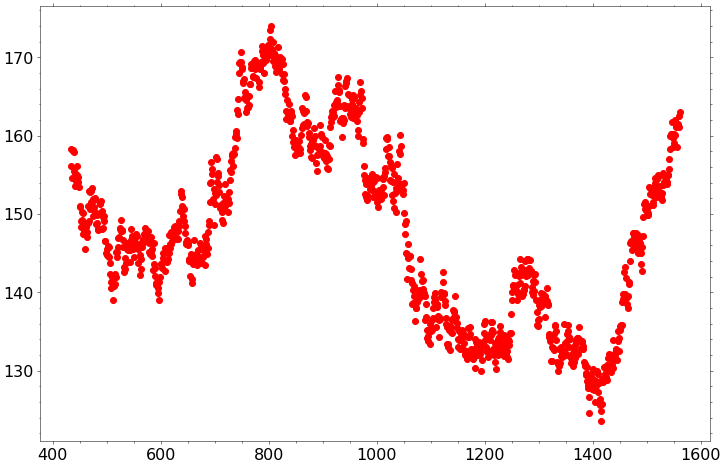

In [5]:
#plot the data
%matplotlib inline
plotting_defaults()
import matplotlib.pyplot as plt
plt.plot(data[:,0], data[:,1], 'ro')

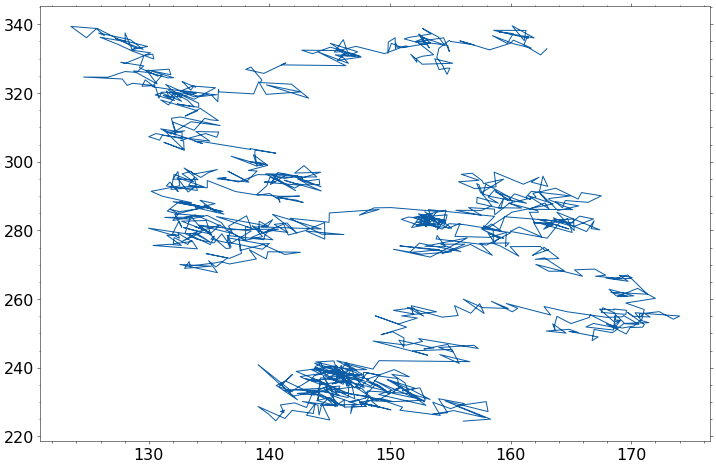

In [6]:
plt.plot(data[:,1], data[:,2])
#plt.line(data[:,1], data[:,2], 'bo')


In [7]:
x = data[:,1]
y = data[:,2]

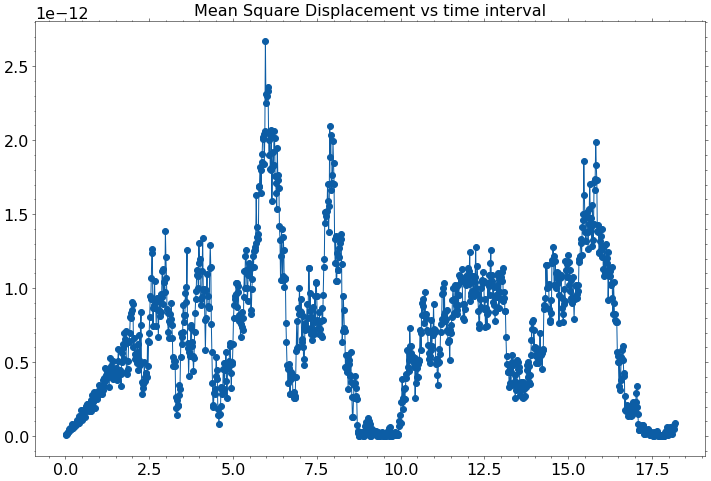

In [8]:
time_interval, avg_square_dev, std_square_dev = msd_func(x)
plotting_defaults()
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(time_interval, avg_square_dev)
plt.plot(time_interval, avg_square_dev)

(1127,) (1127,)


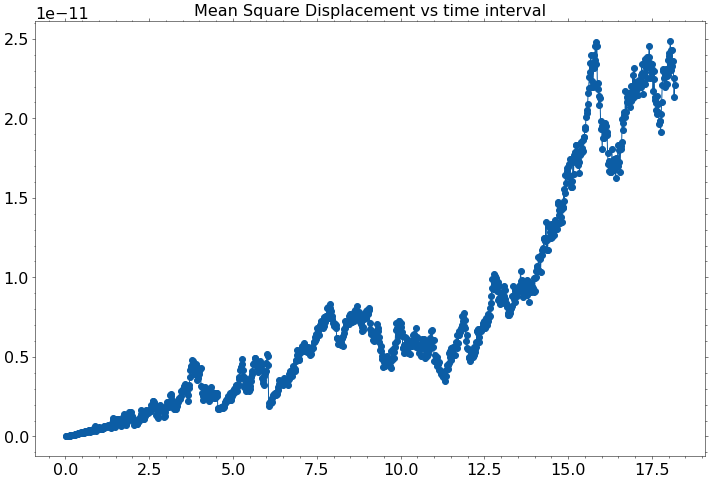

In [9]:
time_interval, avg_square_dev, std_square_dev = msd_func(y)
plotting_defaults()
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
print(np.shape(time_interval), np.shape(avg_square_dev))
plt.scatter(time_interval, avg_square_dev)
plt.plot(time_interval, avg_square_dev)

The viscosity is 0.0036 +/- 0.00005 Pa.s


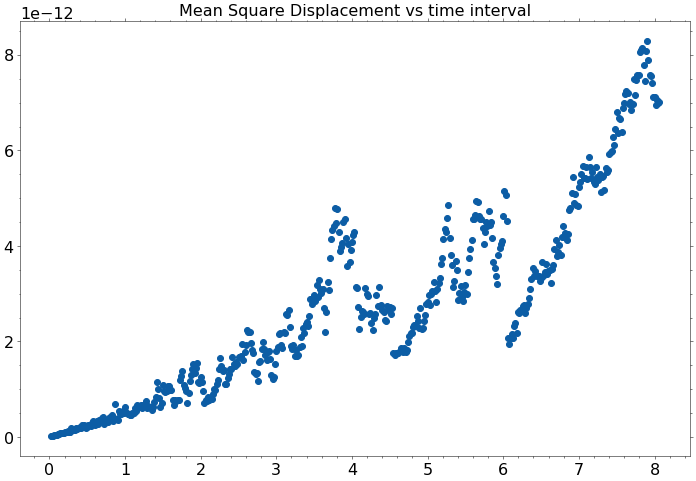

In [10]:
data = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)

time_interval, avg_square_dev, std_square_dev = msd_func(y)
plotting_defaults()

temp_time_interval = time_interval[:500]
temp_square = avg_square_dev[:500]
temp_dev = std_square_dev[:500]
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(temp_time_interval, temp_square)


popt, pcov = curve_fit(func, temp_time_interval, temp_square, sigma=temp_dev)
eta = visc_calc(popt[0], diameter=0.5e-6)
delta_eta = eta * np.sqrt((pcov[0][0] / popt[0] ** 2) + (0.05/291) ** 2)

print(f"The viscosity is {eta:.4f} +/- {delta_eta:.5f} Pa.s")

D = kT / 6 \pi  \nu r

on

The viscosity is 0.0042 +/- 0.00016 Pa.s


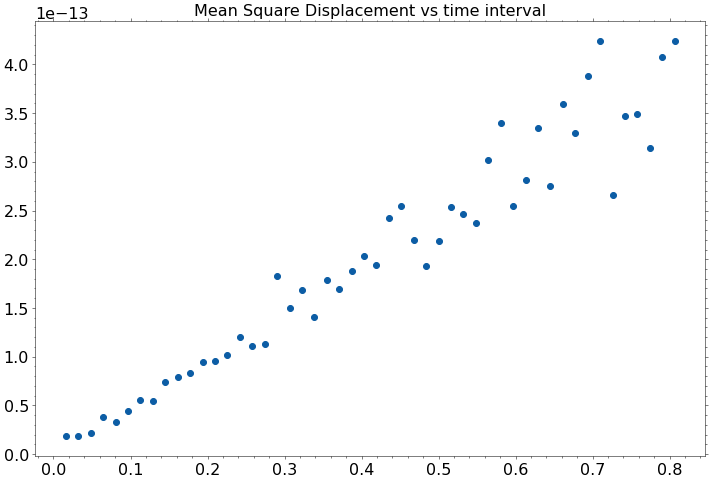

In [11]:
data = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)

time_interval, avg_square_dev, std_square_dev = msd_func(y)
plotting_defaults()

temp_time_interval = time_interval[:50]
temp_square = avg_square_dev[:50]
temp_dev = std_square_dev[:50]
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(temp_time_interval, temp_square)


popt, pcov = curve_fit(func, temp_time_interval, temp_square, sigma=temp_dev)
eta = visc_calc(popt[0], diameter=0.5e-6)
delta_eta = eta * np.sqrt((pcov[0][0] / popt[0] ** 2) + (0.05/291) ** 2)

print(f"The viscosity is {eta:.4f} +/- {delta_eta:.5f} Pa.s")

In [12]:
updated_lines = []
updated_lines_1 = []
updated_lines_2 = []

for times in temp_time_interval:
    updated_lines.append(func(times, popt[0], popt[1]))
    updated_lines_1.append(func(times, popt[0] + np.sqrt(pcov[0][0]), popt[1] - np.sqrt(pcov[1][1])))
    updated_lines_2.append(func(times, popt[0] - np.sqrt(pcov[0][0]), popt[1] + np.sqrt(pcov[1][1])))

print(spearmen_corr_coeff(np.array(temp_square), np.array(updated_lines)))
print(pearson_corr_coeff(temp_square, updated_lines))
print(chi_squared(np.array(temp_square), np.array(updated_lines), np.array(temp_dev)))
print(calculate_r_squared(y=np.array(temp_square), pred=np.array(updated_lines)))

0.97714275
0.96930724
1.6492387
0.8787198


Text(0, 0.5, 'Mean Square Displacement (m^2)')

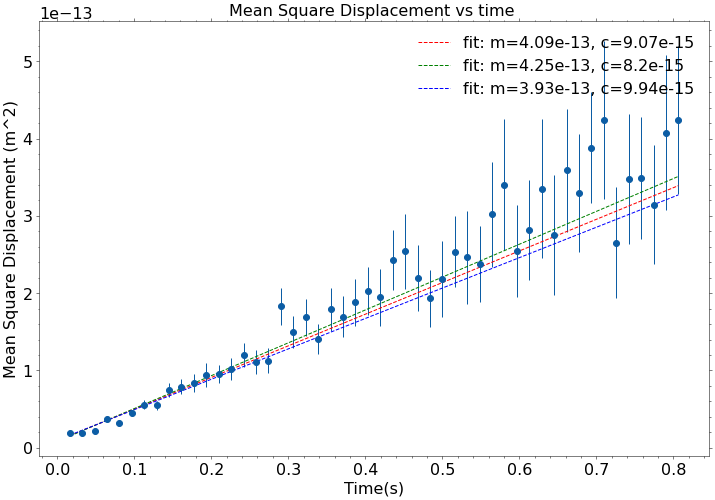

In [13]:
plotting_defaults()
#plot lines with error bars



plt.title("Mean Square Displacement vs time ")
plt.errorbar(temp_time_interval, temp_square, yerr=temp_dev, fmt="o")

plt.plot(temp_time_interval, updated_lines, 'r--', label='fit: m=%5.3g, c=%5.3g' % tuple(popt))
plt.plot(temp_time_interval, updated_lines_1, 'g--', label='fit: m=%5.3g, c=%5.3g' % tuple((popt[0] + np.sqrt(pcov[0][0]), popt[1] - np.sqrt(pcov[1][1]))))
plt.plot(temp_time_interval, updated_lines_2, 'b--', label='fit: m=%5.3g, c=%5.3g' % tuple((popt[0] - np.sqrt(pcov[0][0]), popt[1] + np.sqrt(pcov[1][1]))))
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("Mean Square Displacement (m^2)")

<ErrorbarContainer object of 3 artists>

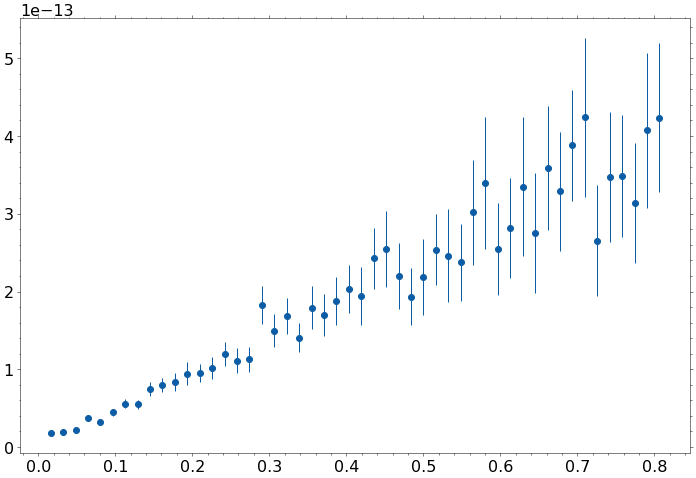

In [14]:
plt.errorbar(temp_time_interval, temp_square, yerr=temp_dev, fmt="o")


<ErrorbarContainer object of 3 artists>

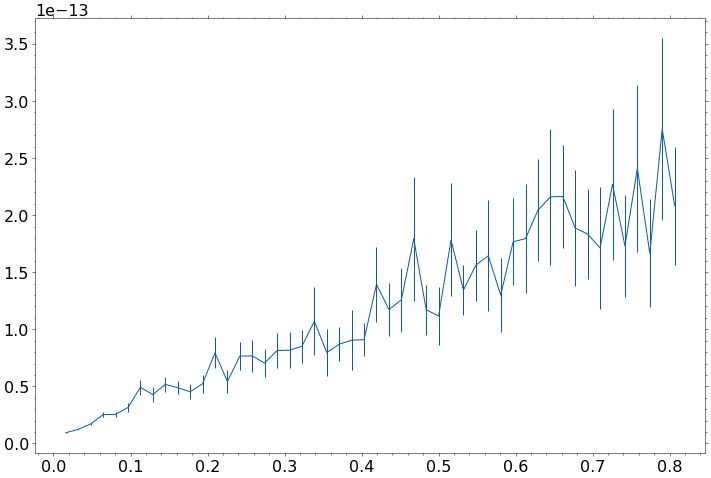

In [15]:
time_interval, avg_square_dev, std_square_dev = msd_func(x)
plt.errorbar(time_interval[:50], avg_square_dev[:50], yerr=std_square_dev[:50])

In [16]:
print(np.shape(x), np.shape(time_interval))

(1128,) (1127,)


In [17]:
import sklearn 
from sklearn.model_selection import train_test_split

time_data, avg_square_dev, _ = msd_func(y)

time = time_data[0:250]
model_y = np.array(avg_square_dev)[0:250]
(X_train, X_test, y_train, y_test) = train_test_split(model_y, time, test_size = .2)

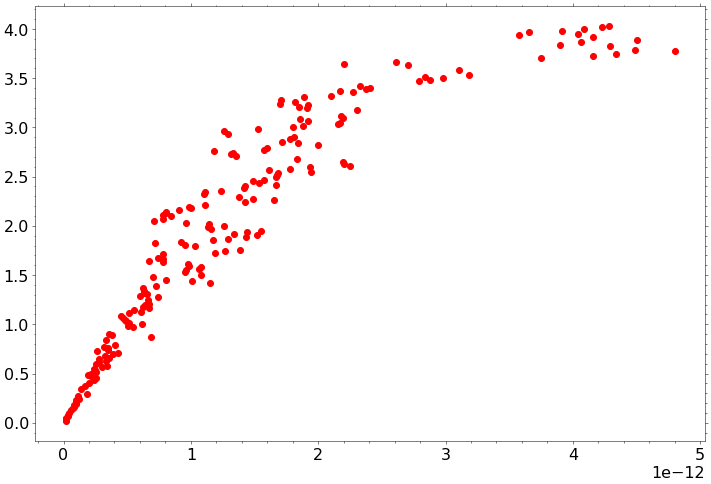

In [18]:
plotting_defaults()
plt.plot(X_train, y_train, 'ro')

In [19]:
from sklearn.dummy import DummyRegressor
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train.reshape(-1,1), np.array(y_train).reshape(-1, 1))
dummy_regressor.predict(X_test.reshape(-1,1))
dummy_regressor.score(X_test, y_test)


-0.022701647860778662

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor

gaussian_reg = GaussianProcessRegressor()
gaussian_reg.fit(X_train.reshape(-1, 1), np.array(y_train).reshape(-1, 1))
gaussian_reg.predict(X_test.reshape(-1,1))
gaussian_reg.score(X_test.reshape(-1, 1), y_test)


-0.022705991283268112

(50, 1) (50,) (50,)
[1.98731995] 2.370967741935484


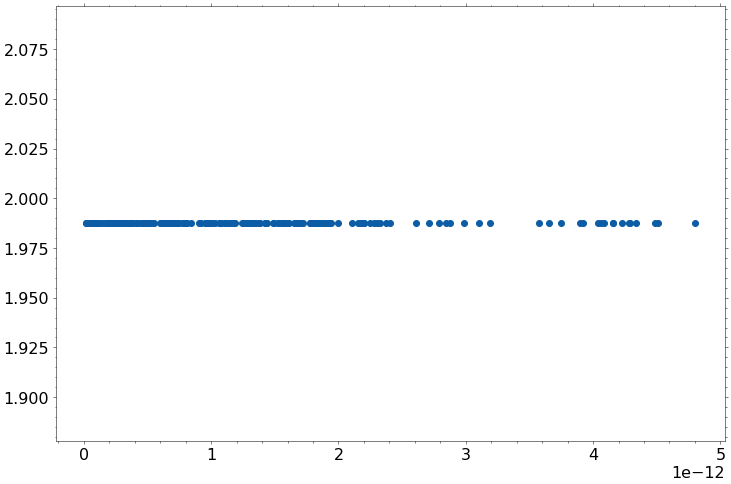

In [21]:
predictions, predictions_std = gaussian_reg.predict(X_test.reshape(-1,1), return_std=True)
fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(1,1,1)
print(np.shape(predictions), np.shape(predictions_std), np.shape(X_test))
#plt.scatter(X_test, y_test)
#plt.errorbar(X_test, predictions, yerr=predictions_std)
print(predictions[0], y_test[0])

pred_x = gaussian_reg.predict(X_train.reshape(-1,1))
plt.scatter(X_train, pred_x)

In [22]:
np.shape(predictions)

(50, 1)

In [23]:
gaussian_reg.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

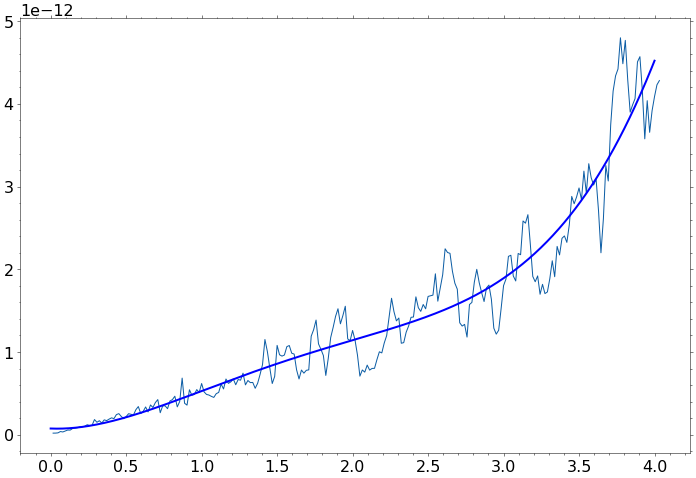

In [24]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


spl = UnivariateSpline(time_data[0:250], avg_square_dev[0:250], k=4)
xs = np.linspace(0, 4, 1000)
spl.set_smoothing_factor(0.1)
plt.plot(time_data[0:250], avg_square_dev[0:250])
plt.plot(xs, spl(xs), 'b', lw=2)


In [25]:
X_train.max()

4.799597550020146e-12

In [26]:
spl.get_coeffs()
spl.get_residual()

2.1328253137929825e-23

# Glycerol Solution

In [27]:
glycerol_dict = {}

glycerol_dict["20"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_20.xml"
glycerol_dict["40"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_40.xml"
glycerol_dict["50"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_50_2.xml"
glycerol_dict["60"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_60.xml"
glycerol_dict["0"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/cleaned_tracking/day3_vid2_Tracks0-3500.xml"
current_tracks = ["0", "20", "40", "50", "60"]


In [28]:

def analyzer(data, x=True, y=False, num_elem=50, full_analysis=False):

    if x:
        data = data[:, 1]
    else:
        data = data[:, 2]
    time_interval, avg_square_dev, std_square_dev = msd_func(data)
    
    temp_time_interval = time_interval[:num_elem]
    temp_square = avg_square_dev[:num_elem]
    temp_dev = std_square_dev[:num_elem]
    popt, pcov = curve_fit(func, temp_time_interval, temp_square, sigma=temp_dev)
   
    eta = visc_calc(popt[0], diameter=0.5e-6)
    delta_eta = eta * np.sqrt((pcov[0][0] / popt[0] ** 2) + (0.05/291) ** 2)


    if full_analysis:
        updated_lines = []
        updated_lines_1 = []
        updated_lines_2 = []
        for times in temp_time_interval:
            updated_lines.append(func(times, popt[0], popt[1]))
            updated_lines_1.append(func(times, popt[0] + np.sqrt(pcov[0][0]), popt[1] - np.sqrt(pcov[1][1])))
            updated_lines_2.append(func(times, popt[0] - np.sqrt(pcov[0][0]), popt[1] + np.sqrt(pcov[1][1])))

        
        print(f"Spearmen corr coeff {spearmen_corr_coeff(np.array(temp_square), np.array(updated_lines))}")
        print(f"Pearson: {pearson_corr_coeff(temp_square, updated_lines)}")
        print(f"CHI-Squared: {chi_squared(np.array(temp_square), np.array(updated_lines), np.array(temp_dev))}")
        print(f"R_SQUARED: {calculate_r_squared(y=np.array(temp_square), pred=np.array(updated_lines))}")
            







    return eta, delta_eta


 0: The viscosity is 0.0009 +/- 0.00004 Pa.s
 10: The viscosity is 0.0038 +/- 0.00011 Pa.s
 20: The viscosity is 0.0069 +/- 0.00044 Pa.s
 30: The viscosity is 0.0058 +/- 0.00041 Pa.s
 40: The viscosity is 0.0002 +/- 0.00000 Pa.s
 50: The viscosity is 0.0118 +/- 0.00231 Pa.s
 60: The viscosity is 0.0022 +/- 0.00002 Pa.s
 70: The viscosity is 0.0310 +/- 0.00176 Pa.s
 80: The viscosity is 0.0483 +/- 0.00238 Pa.s


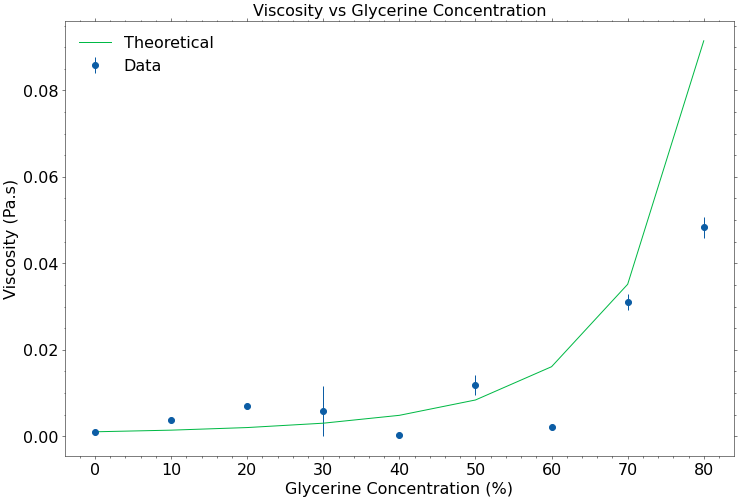

In [29]:
#second round of analysis:
glycerol_dict["20"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_20.xml"
glycerol_dict["40"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_40.xml"
glycerol_dict["50"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_50_2.xml"
glycerol_dict["60"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_60.xml"
glycerol_dict["0"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/cleaned_tracking/day3_vid2_Tracks0-3500.xml"

glycerol_dict["10"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks_two/glycerine_10.xml"
glycerol_dict["30"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks_two/glycerine_30.xml"
glycerol_dict["70"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks_two/glycerine_70.xml"
glycerol_dict["80"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks_two/glycerine_80.xml"


current_tracks = ["0", "10", "20", "30", "40", "50", "60", "70", "80" ]

indexes_tracks = [0,1,0,0,-1,0,0,0,0]
data0 =  load_data(filename=glycerol_dict["0"], multi_particle_index=indexes_tracks[0])
data10 =  load_data(filename=glycerol_dict["10"], multi_particle_index=indexes_tracks[-9])
data20 = load_data(filename=glycerol_dict["20"], multi_particle_index=indexes_tracks[-8])
data30 =  load_data(filename=glycerol_dict["30"], multi_particle_index=indexes_tracks[-7])
data40 = load_data(filename=glycerol_dict["40"], multi_particle_index=indexes_tracks[-6])
data50 = load_data(filename=glycerol_dict["50"], multi_particle_index=indexes_tracks[-5])
data60 = load_data(filename=glycerol_dict["60"], multi_particle_index=indexes_tracks[-4])
data60 = load_data(filename=glycerol_dict["60"], multi_particle_index=indexes_tracks[-3])
data70 = load_data(filename=glycerol_dict["70"], multi_particle_index=indexes_tracks[-2])
data80 = load_data(filename=glycerol_dict["80"], multi_particle_index=indexes_tracks[-1])

eta0,  delta0  = analyzer(data0, x=False, num_elem=20)
eta10, delta10 = analyzer(data10, x=True, num_elem=12)
eta20, delta20 = analyzer(data20, x=True, num_elem=10)
eta30, delta30 = analyzer(data30, x=True, num_elem=10)
eta40, delta40 = analyzer(data40, x=False, num_elem=15)
eta50, delta50 = analyzer(data50, x=True, num_elem=10)
eta60, delta60 = analyzer(data60, 25)
eta70, delta70 = analyzer(data70, 25)
eta80, delta80 = analyzer(data80, x=False, num_elem=10)

result_eta = [eta0, eta10,  eta20, eta30,  eta40,   eta50,   eta60, eta70, eta80]
unc_eta    = [delta0, delta10, delta20, eta30, delta40, delta50, delta60, delta70, delta80]
print(f" 0: The viscosity is {eta0:.4f} +/- {delta0:.5f} Pa.s")
print(f" 10: The viscosity is {eta10:.4f} +/- {delta10:.5f} Pa.s")
print(f" 20: The viscosity is {eta20:.4f} +/- {delta20:.5f} Pa.s")
print(f" 30: The viscosity is {eta30:.4f} +/- {delta30:.5f} Pa.s")

print(f" 40: The viscosity is {eta40:.4f} +/- {delta40:.5f} Pa.s")
print(f" 50: The viscosity is {eta50:.4f} +/- {delta50:.5f} Pa.s")
print(f" 60: The viscosity is {eta60:.4f} +/- {delta60:.5f} Pa.s")
print(f" 70: The viscosity is {eta70:.4f} +/- {delta70:.5f} Pa.s")
print(f" 80: The viscosity is {eta80:.4f} +/- {delta80:.5f} Pa.s")

plt.xlabel("Glycerine Concentration (%)")
plt.ylabel("Viscosity (Pa.s)")
plt.title("Viscosity vs Glycerine Concentration")
plotting_defaults()
plt.errorbar(current_tracks, result_eta, yerr=unc_eta, fmt='o', label="Data")

theoretical_x = np.linspace(0, 80, 9)
glycerine_vol = theoretical_x * 0.01
water_vol = 1 - glycerine_vol
glycerine_array = []
for i in range(len(glycerine_vol)):
    glycerine_array.append(glycerine_calc(water_vol[i], glycerine_vol[i]));



plt.plot(current_tracks, glycerine_array, label="Theoretical")
plt.legend()
# current_tracks = [float(i) for i in current_tracks]
# #seaborn lineplot
# current_tracks_2 = np.array(current_tracks)
# water_vol = 1 - current_tracks_2
# glycerine_array = []
# for i in range(len(current_tracks_2)):
#     glycerine_array.append(glycerine_calc(water_vol[i], current_tracks_2[i]));

# sns.lineplot(x=current_tracks, y=glycerine_array, label="Theoretical")

In [30]:
indexes_tracks = [3, 2, 1, 0, 1]
data0 =  load_data(filename=glycerol_dict["0"], multi_particle_index=indexes_tracks[0])
data20 = load_data(filename=glycerol_dict["20"], multi_particle_index=indexes_tracks[1])
data40 = load_data(filename=glycerol_dict["40"], multi_particle_index=indexes_tracks[2])
data50 = load_data(filename=glycerol_dict["50"], multi_particle_index=indexes_tracks[3])
data60 = load_data(filename=glycerol_dict["60"], multi_particle_index=indexes_tracks[4])

eta0,  delta0  = analyzer(data0, x=False, num_elem=20)
eta20, delta20 = analyzer(data20, x=True, num_elem=10)
eta40, delta40 = analyzer(data40)
eta50, delta50 = analyzer(data50, x=True, num_elem=10)
eta60, delta60 = analyzer(data60, 25)

result_eta = [eta0,   eta20,   eta40,   eta50,   eta60]
unc_eta    = [delta0, delta20, delta40, delta50, delta60]


In [31]:
print(f" 0: The viscosity is {eta0:.4f} +/- {delta0:.5f} Pa.s")
print(f" 20: The viscosity is {eta20:.4f} +/- {delta20:.5f} Pa.s")
print(f" 40: The viscosity is {eta40:.4f} +/- {delta40:.5f} Pa.s")
print(f" 50: The viscosity is {eta50:.4f} +/- {delta50:.5f} Pa.s")
print(f" 60: The viscosity is {eta60:.4f} +/- {delta60:.5f} Pa.s")

 0: The viscosity is 0.0011 +/- 0.00005 Pa.s
 20: The viscosity is 0.0040 +/- 0.00019 Pa.s
 40: The viscosity is 0.0094 +/- 0.00029 Pa.s
 50: The viscosity is 0.0118 +/- 0.00231 Pa.s
 60: The viscosity is 0.0145 +/- 0.00030 Pa.s


It is important to note that to do this calculation we used the approximation that, alpha the relationship is equal to 1. Although this valid for low visciousity solutions like 0% water. This is not true as we increase the viscousity.

To get a comparision curve, we use data found in:
http://materiel-physique.ens-lyon.fr/Notices/P105GEb_Table%20de%20viscosit%C3%A9%20Glyc%C3%A9rol-eau_ENSLYON.pdf


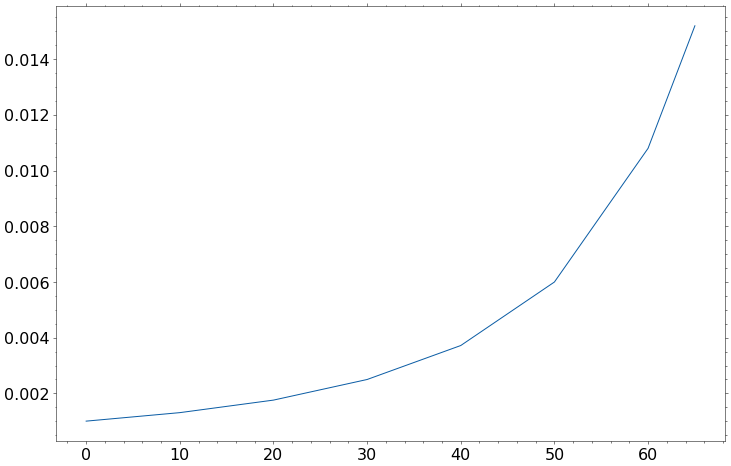

In [32]:
plotting_defaults()
author_x = [0,10,20,30,40,50,60,65,70,75,80,85,90,91,92,93,94,95,96,97,98,99,100]
author_visc = [1.005, 1.31, 1.76, 2.50, 3.72, 6.00, 10.8, 15.2, 22.5, 35.5, 60.1, 109, 219, 259, 310, 367, 437, 523, 624, 765, 939, 1150, 1412]

author_visc = np.array(author_visc)*0.001
plt.plot(author_x[:8], author_visc[:8])

In [33]:
theoretical_x = np.linspace(0, 80, 9)
glycerine_vol = theoretical_x * 0.01
water_vol = 1 - glycerine_vol
glycerine_array = []
for i in range(len(glycerine_vol)):
    glycerine_array.append(glycerine_calc(water_vol[i], glycerine_vol[i]));


In [34]:
theoretical_x

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.])

In [35]:
#compute the residual sum os squares between the eta and the theoretical eta
def rss(eta, theoretical_eta):
    return np.sum((eta - theoretical_eta) ** 2)
    

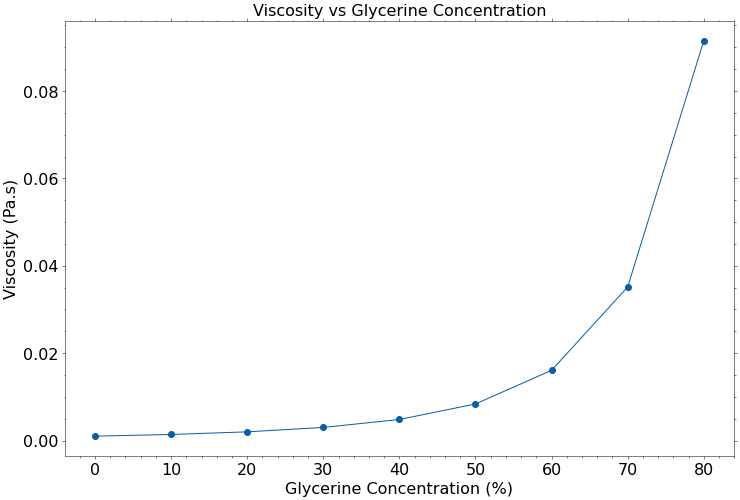

In [36]:
plt.scatter(theoretical_x, glycerine_array)
plt.xlabel("Glycerine Concentration (%)")
plt.ylabel("Viscosity (Pa.s)")
plt.title("Viscosity vs Glycerine Concentration")
plt.plot(theoretical_x, glycerine_array)
#plt.errorbar(current_tracks, result_eta, yerr=unc_eta, fmt='o', label="Data")


# Potential finding

In [37]:
#read the data in:

data = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)
print(f"The number of data points is {len(data)}")



The number of data points is 1128


In [38]:
#calculate acceleration and velocity between data point
def accel_cal(data, fps=62.0, immersion=True):
    """Calculate the acceleration between data points"""
    velocity = []
    accel = []
    timestep = 1 / fps
    if immersion:
        calibration_factor = 0.6*1e-3*0.1/979.3
    else:
        calibration_factor = (0.1*0.001)/1094.4
    data = data * calibration_factor


    temp_x = np.array(data) - np.array(data)[0]
    temp_data = []
    for i in range(len(temp_x)):
        temp_data.append(temp_x[i])
        if i > 0:
            vel = (temp_data[-1] - temp_data[-2]) / timestep #this is the velocity at i = 0
            velocity.append(vel)
        if i > 1:
            acc = (velocity[-1] - velocity[-2]) / timestep
            accel.append(acc)
    data = np.array(data)
    velocity = np.array(velocity)
    accel = np.array(accel)

    data = data[:len(accel)]
    velocity = velocity[:len(accel)]
    
    return data, velocity, accel

In [39]:
disp_x, v_x, a_x = accel_cal(x)
disp_y, v_y, a_y = accel_cal(y)

mod_accel = np.sqrt(a_x**2 + a_y**2)
mod_velocity = np.sqrt(v_x**2 + v_y**2)

(array([ 21., 148., 134., 141., 195., 141., 127., 108.,  69.,  42.]),
 array([-1.99330919e-06, -1.68412735e-06, -1.37494550e-06, -1.06576366e-06,
        -7.56581819e-07, -4.47399976e-07, -1.38218133e-07,  1.70963709e-07,
         4.80145552e-07,  7.89327395e-07,  1.09850924e-06]),
 <BarContainer object of 10 artists>)

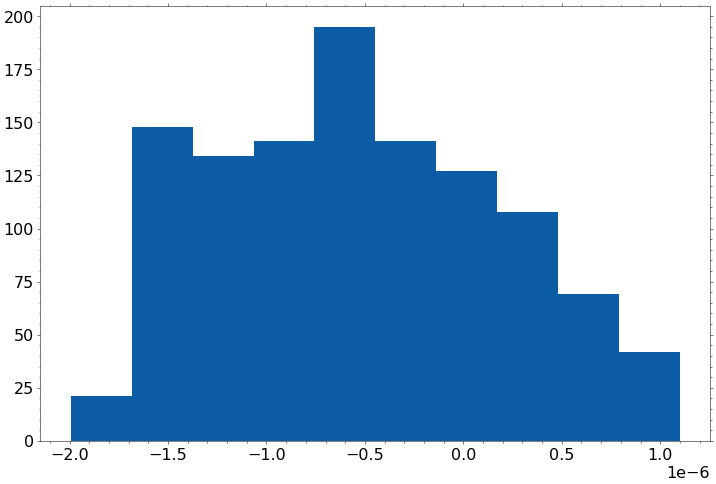

In [40]:
disp_x[0]

centered_x = disp_x - disp_x[0]
plt.hist(centered_x)

calculate the kurtosis and third moment of a data


In [41]:
#calculate the kurtosis of the data
#kurtosis
from scipy.stats import kurtosis
print(kurtosis(centered_x))


-0.9335576077504686


Text(0, 0.5, 'Count')

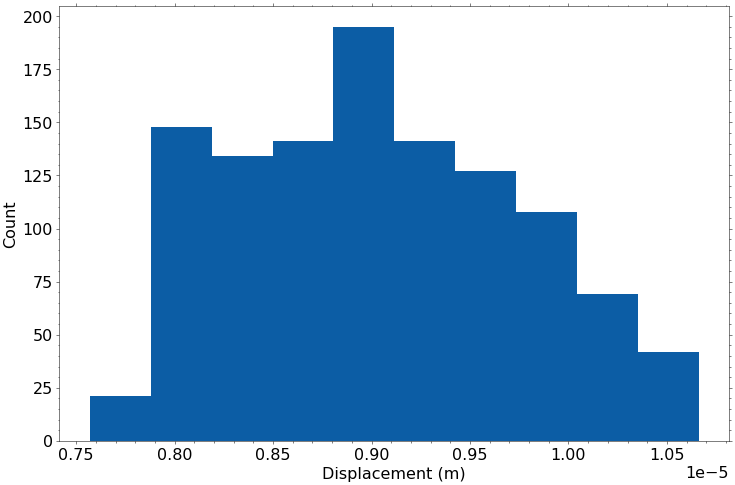

In [42]:
plt.hist(disp_x)
#x labels
plt.xlabel("Displacement (m)")
plt.ylabel("Count")

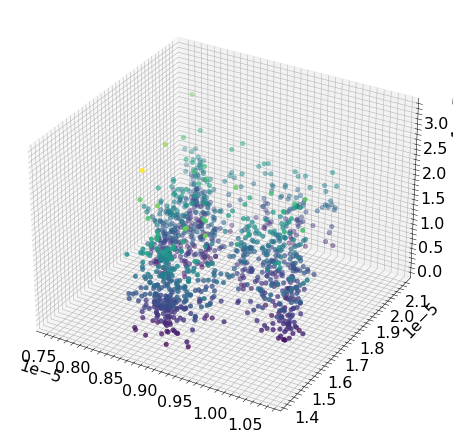

In [43]:
#3D plot of the data
plotting_defaults()



from scipy.stats import kde



fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(disp_x, disp_y, mod_velocity, c=mod_velocity, cmap='viridis', linewidth=0.5)

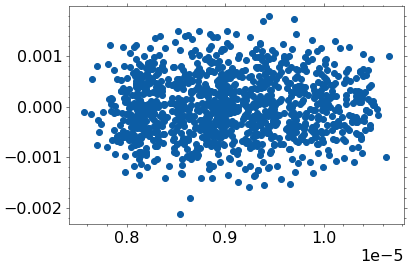

In [44]:
plotting_defaults()
%matplotlib inline
plt.scatter(disp_x, a_x)

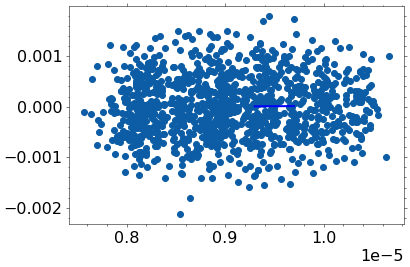

In [45]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
def lexsort(*arrays):
    indexes = np.lexsort(arrays[::-1])
    return tuple((a[indexes] for a in arrays))
disp_x_t, a_x_t = lexsort(disp_x, a_x)
spl = UnivariateSpline(disp_x_t, a_x_t, k=4)

xs = np.linspace(9.3e-6, 9.7e-6, 1000)
spl.set_smoothing_factor(0.5)
plt.scatter(disp_x_t, a_x_t)
plt.plot(xs, spl(xs), 'b', lw=2)

# Lazer zoom zoom


Now we have a lazer we will do some stuff.

In [46]:
#read data in
data_gaussian = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)
print(f"The number of data points is {len(data_gaussian)}")

x_gaussian = data_gaussian[:,1]
y_gaussian = data_gaussian[:,2]

time_interval, avg_square_dev, std_square_dev = msd_func(x_gaussian, immersion=True)





The number of data points is 1128


We are only intrested in the first interval and dont really care about the others.

In [47]:
#read text from a file as a numpy array
FILE_LOCATION_TWO = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/laser_tweezers_two"
FIlE_LOCATION_TWO_LABELS = FILE_LOCATION_TWO + "/current_labels.txt"
CURRENT_POWER_LOC = FILE_LOCATION_TWO + "/laser_power.csv"
data = np.loadtxt(FIlE_LOCATION_TWO_LABELS, delimiter=',', skiprows=0)
#print(data)
print(data.shape)

#create a dictionary of the data
data_dict = {}
power_dict = {}
data = np.genfromtxt(CURRENT_POWER_LOC, delimiter=',', skip_header=1)
for i in range(len(data)):

    power_dict[int(data[i][0])] = data[i][1]

data = np.loadtxt(FIlE_LOCATION_TWO_LABELS, delimiter=',', skiprows=0)


for i in range(len(data)):
    try:
        data_dict[int(data[i][0])] = power_dict.get(data[i][1])
    except:
        pass

data_dict


(11, 2)


{1: 8.38,
 2: 7.92,
 3: 6.97,
 4: 6.85,
 5: 6.08,
 6: 5.52,
 7: 4.84,
 8: 4.21,
 9: 3.56,
 10: 2.91,
 11: 2.28}

In [63]:
#read in all the files in a folder and load them into an array

temp_x_array, temp_y_array, current_array = [], [], []

rmse_x_array, rmse_y_array = [], []
squared_temp = []


#Kappa vals has the format, [kappa_x, unc_kappa_x, kappa_y, unc_kappa_y]
kappa_vals = []

calibration_factor = 0.6*1e-3*0.1/979.3

potential_x, potential_y = [], []


test_rmse_x = 0
test_rmse_y = 0

i = 0
for filename in os.listdir(FILE_LOCATION_TWO):
    video_code = filename.split("_")[1]
    video_code = video_code[3:]
    
    try:
        video_code = int(video_code)

        if data_dict.get(video_code):
            
            #load data of the file
            temp_filename = FILE_LOCATION_TWO + "/" + filename
            temp_data = load_data(filename=temp_filename, multi_particle_index=0)
            temp_t, temp_x, temp_y = temp_data[:,0], temp_data[:,1], temp_data[:,2]

            #calibration factor of the data
            temp_x = temp_x * calibration_factor
            temp_y = temp_y * calibration_factor
            
            #center the data
            temp_t = temp_t - temp_t[0]
            temp_x = temp_x - temp_x[0]
            temp_y = temp_y - temp_y[0]
            
            #we calculate the kappa of the x and y data
            temp_kappa_x = kappa_calculator(temp_x)

            break_point_data = temp_x
            break_point_kappa = temp_kappa_x
            temp_kappa_y = kappa_calculator(temp_y)

            #append the kappa values to the array
            kappa_vals.append([temp_kappa_x, temp_kappa_y])

            temp_potential_x = (np.array(temp_x) ** 2) * temp_kappa_x[0]
            temp_potential_y = (np.array(temp_y) ** 2) * temp_kappa_y[0]

            potential_x.append([temp_x, temp_potential_x])
            potential_y.append([temp_y, temp_potential_y])

            temp_rmse_x = msd_func(temp_x, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)[1][0]
            temp_rmse_y = msd_func(temp_y, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)[1][0]

            if i == 2:    
                time_test_x, test_rmse_x, _ = msd_func(temp_x, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)
                time_test_y, test_rmse_y, _ = msd_func(temp_y, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)



            rmse_x_array.append(temp_rmse_x)
            rmse_y_array.append(temp_rmse_y)
            temp_x_array.append(temp_x), temp_y_array.append(temp_y), current_array.append(data_dict.get(video_code))
            squared_temp.append(np.sqrt(temp_x**2 + temp_y**2))


            i += 1
        else:
            pass
    except:
        pass  



rmse_x_array = np.array(rmse_x_array).flatten()
rmse_y_array = np.array(rmse_y_array).flatten()
array_x_flattened = np.array(temp_x).flatten()
array_y_flattened = np.array(temp_y).flatten()
squared_temp = np.array(squared_temp).flatten()
kappa_vals = np.array(kappa_vals)


/tmp/ipykernel_27406/4182281455.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  squared_temp = np.array(squared_temp).flatten()


In [64]:
# #FOR 2 MICROMETER PARTICLE
# index_removal = []
# for i, elem in enumerate(test_rmse_x):
#     if time_test_x[i] > 0.4:
#         if  0.1 * 1e-27 < elem < 0.5 * 1e-27:
#             pass
#         else:
#             print(elem, time_test_x[i])
#             index_removal.append(i)


# time_test_x = np.delete(time_test_x, index_removal)
# test_rmse_x = np.delete(test_rmse_x, index_removal) 

# import matplotlib.pyplot as plt
# from pandas import plotting
# from scipy.interpolate import UnivariateSpline

# plotting_defaults()



# bins = np.linspace(0.0,4,10)
# binned_means = []
# print(np.shape(time_test_x))
# for i in range(len(bins)-1):

#     idx = np.where((np.array(time_test_x)>bins[i]) & (np.array(time_test_x)<bins[i+1]))[0]
#     temp_array = test_rmse_x[idx[0]:idx[-1] + 1]
    
#     binned_means.append(np.mean(temp_array))




# _array_ , _array_2 = [], []

# for i, elem in enumerate(time_test_x):
#     if elem > 0.2:
#         pass
#     else:
#         _array_.append(elem)
#         _array_2.append(test_rmse_x[i])


# _array_ = [*_array_, *bins[1:]]
# _array_2 = [*_array_2, *binned_means]

# #plt.scatter(time_test_x[0:10], test_rmse_x[0:10])

# #plt.scatter(bins[1:], binned_means)

# #plot two figures in same plot
# fig, (ax1,ax2) = plt.subplots(1, 2)



# ax1.scatter(_array_, _array_2, color="red")

# spl = UnivariateSpline(_array_, _array_2, k=3)
# xs = np.linspace(0, 3.5, 1000)
# spl.set_smoothing_factor(0.001)
# #plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
# ax1.plot(xs, spl(xs), 'b', lw=2)


# ax2.scatter(_array_, _array_2, color="red")

# spl = UnivariateSpline(np.log10(_array_), np.log10(_array_2), k=2)
# xs = np.logspace(0, 3.5, 1000)
# spl.set_smoothing_factor(0.001)
# #plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
# #ax2.plot(xs, spl(xs), 'b', lw=2)
# ax2.set_yscale("log")
# ax2.set_xscale("log")

# ax1.set_xlabel("Time (s)")
# ax1.set_ylabel("MSD (m^2)")

# ax2.set_xlabel("Time (s)")
# ax2.set_ylabel("MSD (m^2)")

# #ax1 set title
# ax1.set_title("MSD vs Time")
# ax2.set_title("MSD vs Time (log-log)")

In [65]:

#FOR 0.5 MICROMETER PARTICLE
index_removal = []
for i, elem in enumerate(test_rmse_x):
    if time_test_x[i] > 0.4:
        if  0.1 * 1e-31 < elem < 0.5 * 1e-27:
            pass
        else:
            print(elem, time_test_x[i])
            index_removal.append(i)


time_test_x = np.delete(time_test_x, index_removal)
test_rmse_x = np.delete(test_rmse_x, index_removal) 

9.51709456699219e-33 15.197472353870461
4.626963333487181e-33 15.655608214849924
7.828735249971967e-33 19.131121642969987
5.837308027545724e-33 19.21011058451817
5.170171323822189e-34 19.810426540284364
7.133601416991163e-33 21.532385466034757
1.5986045530204655e-33 22.132701421800952
6.60252505437821e-34 22.211690363349135
6.76671014809855e-33 22.290679304897317
1.1157483638723267e-33 22.32227488151659
2.007058707063237e-34 22.638230647709324
1.61524830122899e-33 22.76461295418642
3.242240327780589e-33 22.79620853080569
6.139175940112436e-33 22.969984202211695
4.670485720369802e-37 22.985781990521332
9.24813851215162e-34 23.001579778830965
8.581949602165799e-33 23.333333333333336
2.7611437263466438e-33 23.69668246445498
1.267284358605899e-33 23.949447077409165
1.2803272113949944e-34 24.21800947867299
7.188234108649874e-33 24.36018957345972
1.556381630972939e-33 24.45497630331754
9.880460168543379e-34 24.50236966824645
8.846527438112775e-33 24.565560821484997
7.577501926224114e-35 24.7

(2604,)
(22,) (22,)


Text(0.5, 1.0, 'MSD vs Time (log-log)')

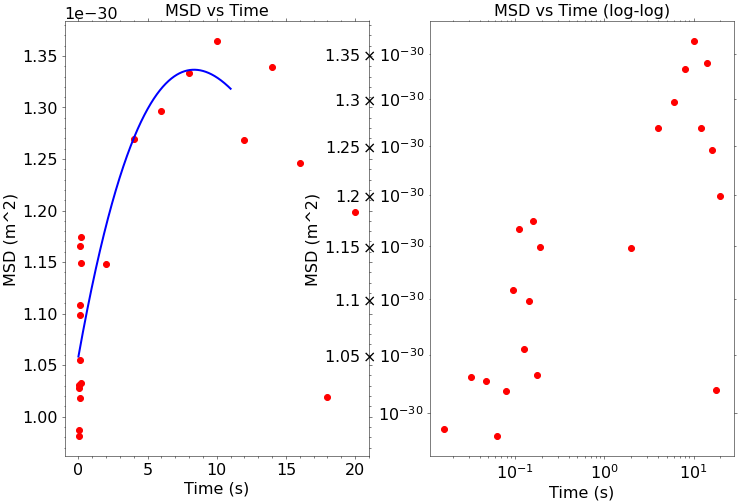

In [66]:

plotting_defaults()



bins = np.linspace(0.0,20,11)
binned_means = []
binned_std = []
print(np.shape(time_test_x))
for i in range(len(bins)-1):

    idx = np.where((np.array(time_test_x)>bins[i]) & (np.array(time_test_x)<bins[i+1]))[0]
    temp_array = test_rmse_x[idx[0]:idx[-1] + 1]
    
    binned_means.append(np.mean(temp_array))
    binned_std.append(np.std(temp_array))




_array_ , _array_2 = [], []
_array_3 = []

for i, elem in enumerate(time_test_x):
    if elem > 0.2:
        pass
    else:
        _array_.append(elem)
        #_array_.append(0.00001)
        _array_2.append(test_rmse_x[i])


_array_ = [*_array_, *bins[1:]]
_array_2 = [*_array_2, *binned_means]
print(np.shape(_array_2), np.shape(_array_))

#plt.scatter(time_test_x[0:10], test_rmse_x[0:10])

#plt.scatter(bins[1:], binned_means)

#plot two figures in same plot
fig, (ax1,ax2) = plt.subplots(1, 2)



ax1.scatter(_array_, _array_2, color="red")

spl = UnivariateSpline(_array_, _array_2, k=3)
xs = np.linspace(0, 11, 1000)
spl.set_smoothing_factor(0.001)
#plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
ax1.plot(xs, spl(xs), 'b', lw=2)


ax2.scatter(_array_, _array_2, color="red")

#spl = UnivariateSpline(np.log10(_array_), np.log10(_array_2), k=2)
#xs = np.logspace(0, 3.5, 1000)
#spl.set_smoothing_factor(0.001)
#plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
#ax2.plot(xs, spl(xs), 'b', lw=2)
ax2.set_yscale("log")
ax2.set_xscale("log")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("MSD (m^2)")

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("MSD (m^2)")

#ax1 set title
ax1.set_title("MSD vs Time")
ax2.set_title("MSD vs Time (log-log)")

In [67]:
idx

array([1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147,
       1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158,
       1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169,
       1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180,
       1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191,
       1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202,
       1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213,
       1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224,
       1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235,
       1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246,
       1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257,
       1258, 1259])

In [70]:
# fig, (ax1,ax2) = plt.subplots(1, 2)



# ax1.scatter(_array_, _array_2, color="red")

# spl = UnivariateSpline(_array_, _array_2, k=3)
# xs = np.linspace(0, 11, 1000)
# spl.set_smoothing_factor(0.001)
# #plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
# ax1.plot(xs, spl(xs), 'b', lw=2, label="0.5")
# ax1.plot(temp_xs, spl_temp, "green", lw=2, label="2.0")

# ax2.scatter(_array_, _array_2, color="red", label="0.5")
# ax2.scatter(temp_array_1, temp_array_2, color="green", label="2")
# #spl = UnivariateSpline(np.log10(_array_), np.log10(_array_2), k=2)
# #xs = np.logspace(0, 3.5, 1000)
# #spl.set_smoothing_factor(0.001)
# #plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
# #ax2.plot(xs, spl(xs), 'b', lw=2)
# ax2.set_yscale("log")
# ax2.set_xscale("log")

# ax1.set_xlabel("Time (s)")
# ax1.set_ylabel("MSD (m^2)")

# ax2.set_xlabel("Time (s)")
# ax2.set_ylabel("MSD (m^2)")

# #ax1 set title
# ax1.set_title("MSD vs Time")
# ax2.set_title("MSD vs Time (log-log)")
# ax1.legend()
# ax2.legend()

/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


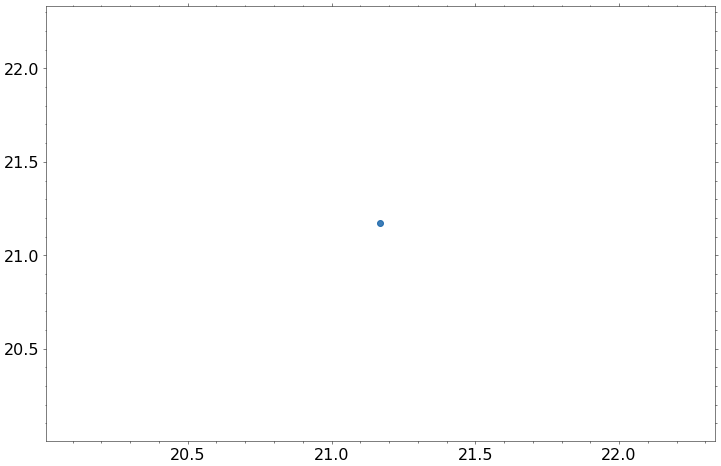

In [71]:
from scipy.stats import binned_statistic

bin_means = binned_statistic(test_rmse_x, time_test_x, statistic='mean', bins=1)[0]
bin_time_means = binned_statistic(time_test_x, time_test_x, statistic='mean', bins=1)[0]
sns.regplot(bin_means, bin_time_means);
ax.set_xscale("log")
ax.set_yscale("log")

In [72]:
binned_statistic(test_rmse_x, test_rmse_x, statistic='mean', bins=30)

BinnedStatisticResult(statistic=array([1.31640368e-31, 4.53443322e-31, 7.53103959e-31, 1.05942897e-30,
       1.35552206e-30, 1.65462336e-30, 1.95159988e-30, 2.23104126e-30,
       2.57402395e-30, 2.87790690e-30, 3.15982781e-30, 3.45749053e-30,
       3.77057003e-30, 4.09170772e-30, 4.30908653e-30, 4.75234283e-30,
       4.96257528e-30, 5.23230636e-30,            nan, 5.93636187e-30,
       6.07526293e-30, 6.56097712e-30,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, 9.02719344e-30]), bin_edges=array([1.00351585e-32, 3.10607101e-31, 6.11179044e-31, 9.11750986e-31,
       1.21232293e-30, 1.51289487e-30, 1.81346681e-30, 2.11403876e-30,
       2.41461070e-30, 2.71518264e-30, 3.01575459e-30, 3.31632653e-30,
       3.61689847e-30, 3.91747041e-30, 4.21804236e-30, 4.51861430e-30,
       4.81918624e-30, 5.11975818e-30, 5.42033013e-30, 5.72090207e-30,
       6.02147401e-30, 6.32204595e-30, 6.62261790e-30, 6.92318984

/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


DeviceArray(0.12074737, dtype=float32)

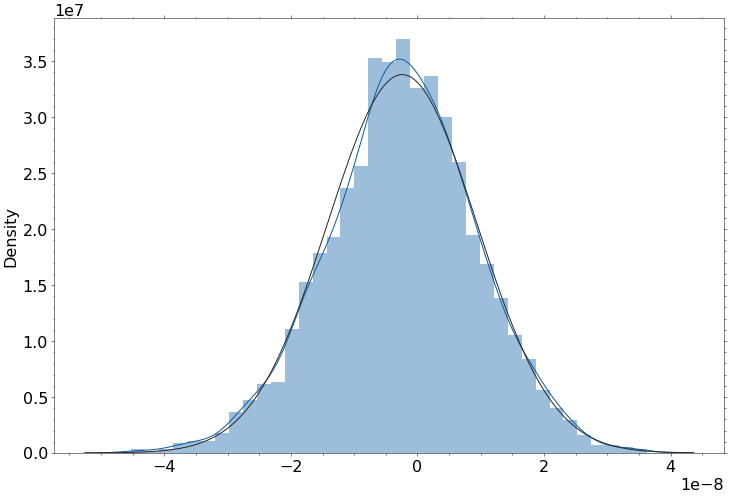

In [73]:

#numpy flatten array
import numpy as np
import seaborn as sns
from scipy.stats import norm

# Generate simulated data
n_samples = 100
rng = np.random.RandomState(0)
data = rng.standard_normal(n_samples)

# Fit Gaussian distribution and plot
sns.distplot(array_x_flattened, fit=norm, kde=True)
#sns.distplot(array_y_flattened, fit=norm, kde=False)

import scipy
mu, sigma = scipy.stats.norm.fit(array_x_flattened)


covariance_matrix = np.cov(array_x_flattened, y = array_y_flattened)
covariance_matrix

pearson_corr_coeff(array_x_flattened, array_y_flattened)

In [74]:
print(f"mean {mu} and sigma {sigma}")



mean -2.4128035512495073e-09 and sigma 1.1802768656223442e-08


As we know the data is distributed normally, we can extract the the value of Kappa, as we know

$N(x | \mu, \sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}exp(-\frac{1}{2\sigma^2}(x - \mu)^2)$

we also know that the Gaussian PDF for our distribution is theoretically,
$ C exp (\frac{-\kappa}{2 k_b T}(x - x_o)^2)$

therefore,

$\frac{\kappa}{2k_bT} = \frac{1}{2\sigma^2}$

In [75]:
print(np.shape(kappa_vals))

print(np.shape(kappa_vals[:, 0, 0]))
kappa_vals[:, 0, 0]

(11, 2, 2)
(11,)


array([1.26781189e-05, 1.19137799e-05, 1.75720921e-05, 2.88610172e-05,
       1.47642305e-05, 9.56174531e-05, 7.24526259e-05, 1.99871072e-05,
       6.36483550e-07, 1.02072885e-05, 2.90390974e-05])

In [76]:
# plotting_defaults()
# plt.scatter(current_array, kappa_vals[:, 0, 0], color="green", label="kappa_x")

# plt.scatter(current_array, kappa_vals[:, 1, 0], color='red', label="kappa_y")



/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The R squared value for kappa_x is 0.8067832589149475
The R squared value for kappa_y is 0.407047837972641


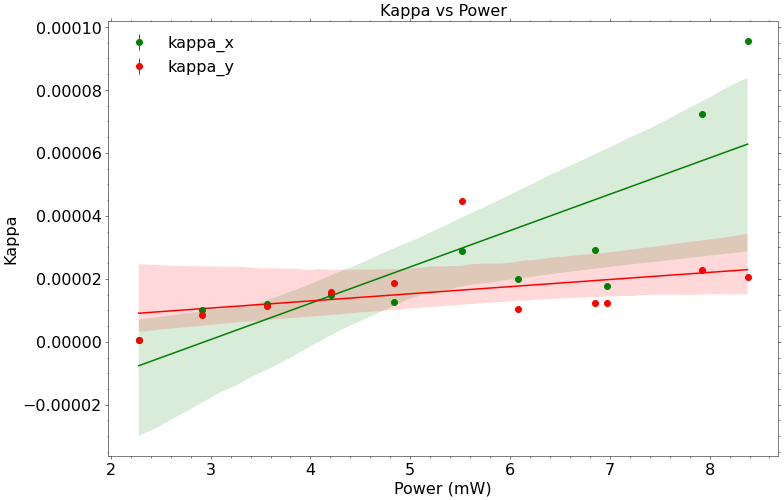

In [77]:
ax = sns.regplot(current_array, kappa_vals[:, 0, 0], color="green",  scatter=False)
ax = sns.regplot(current_array, kappa_vals[:, 1, 0], color='red',  scatter=False)
#matplotlib plot with error bars
ax.errorbar(current_array, kappa_vals[:, 0, 0], yerr=kappa_vals[:, 0, 1], color="green", label="kappa_x", fmt="o")
ax.errorbar(current_array, kappa_vals[:, 1, 0], yerr=kappa_vals[:, 1, 1], color='red', label="kappa_y", fmt="o")
ax.set_xlabel("Power (mW)")
ax.set_ylabel("Kappa")
ax.set_title("Kappa vs Power")
ax.set_label("")
ax.legend()


print(f"The R squared value for kappa_x is {pearson_corr_coeff(current_array, kappa_vals[:, 0, 0])}")

print(f"The R squared value for kappa_y is {pearson_corr_coeff(current_array, kappa_vals[:, 1, 0])}")

Uncertainities in the measurements found by boostrapping with 1000 parameters and 95% confidence intervals are shown

Now we find the potential landscape for x and y

In [78]:
temp_current_array = current_array
temp_kappa_values = kappa_vals

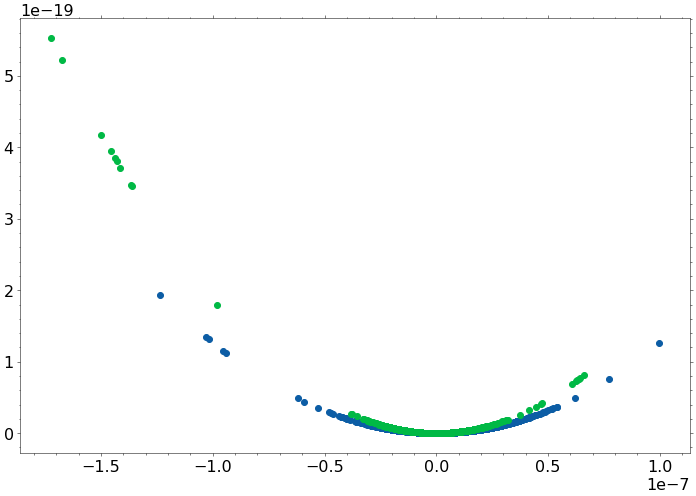

In [79]:
plotting_defaults()
plt.scatter(potential_x[0][0],potential_x[0][1])
plt.scatter(potential_y[0][0],potential_y[0][1])

In [80]:
np.shape(kappa_vals)

(11, 2, 2)

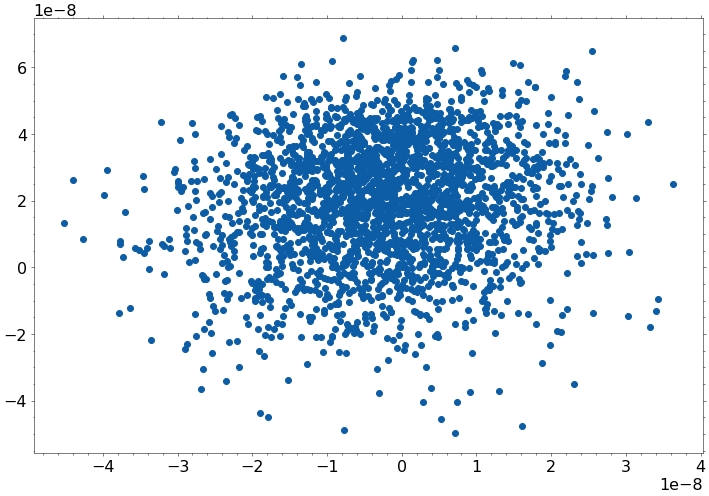

In [81]:
plt.plot(array_x_flattened, array_y_flattened, 'o')

In [86]:
np.shape(current_array), np.shape(squared_temp)

((11,), (11,))

In [90]:
# plt.plot(current_array, squared_temp, 'o')

## Finding X(t)


We want to plot, 
\
$<\Delta x(t)^2> = A( 1- exp(\frac{\kappa \tau}{\gamma}))$

We know kappa for each value of the current, so for each current, we can calculate x(t)  vs t. 


Plotting, 
$ \frac{\gamma}{\kappa \tau}  log( - <\Delta x(t)^2> / A)  = 1 $

(DONE ABOVE
)

# SIMULATION OF PARTICLE ON THE TRAP

In [91]:
from src.simulation import *
trapped_particle()

Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
Hit wall
H